In [1]:
import os
import sys
import time
import random
import numpy as np
import torch
from pathlib import Path

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from density_decoding.utils.utils import set_seed

from density_decoding.utils.data_utils import (
    BaseDataLoader,
    IBLDataLoader, 
)
from density_decoding.decoders.behavior_decoder import (
    generic_decoder,
    sliding_window_decoder
)
from density_decoding.decode_pipeline import decode_pipeline

set_seed(666)

device = torch.device("cpu")

In [2]:
%matplotlib inline
plt.rc("figure", dpi=200)
SMALL_SIZE = 8
BIGGER_SIZE = 10
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=1)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=3)

#### IBL

We also include a tutorial for working with IBL datasets, which are public and free to download.

First, let's prepare the IBL data loader. 

In [3]:
def load_data_from_h5(path, file_name):
    import h5py
    file_path = Path(path)/file_name
    with h5py.File(file_path, "r") as h5:
        spike_times = h5["times_samples"][:]
        spike_channels = h5["channels"][:]
        spike_amps = h5["denoised_ptp_amplitudes"][:]
        x, _, z, _ = h5["point_source_localizations"][:].T
    spike_features = np.c_[x, z, spike_amps]
    return spike_times, spike_channels, spike_features

We load the **spike times**, **spike channels** and **spike features**. 

In [4]:
pid = "c4f6665f-8be5-476b-a6e8-d81eeae9279d"

path = "/u/yzhang39/density_decoding/data/"
file_name = f"{pid}_feats.h5"
spike_times, spike_channels, spike_features = load_data_from_h5(path, file_name)

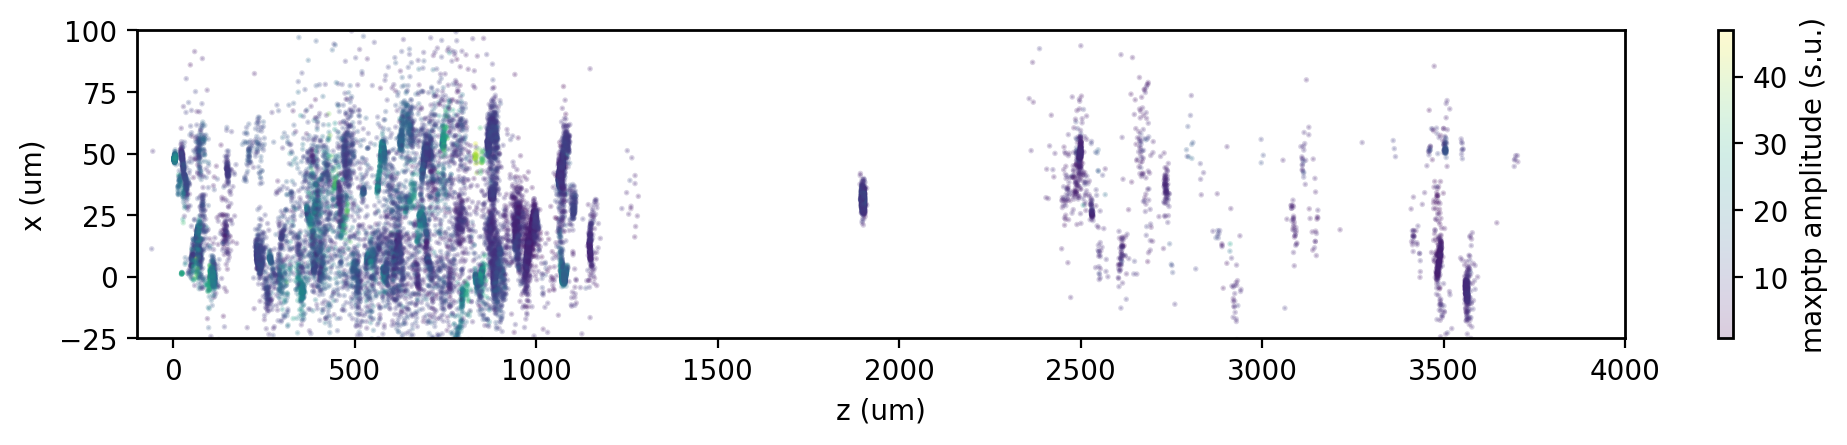

In [6]:
n_spikes_display = 2_0000
x, z, maxptp = spike_features[:n_spikes_display].T

fig, ax = plt.subplots(1, 1, figsize=(12,2))
im = ax.scatter(z, x, c=maxptp, s=1, alpha=.2)
cbar = plt.colorbar(im, ax=ax)
ax.set_xlim(-100, 4000)
ax.set_ylim(-25, 100)
ax.set_xlabel("z (um)")
ax.set_ylabel("x (um)")
cbar.set_label("maxptp amplitude (s.u.)")
plt.show()

In [7]:
ibl_data_loader = IBLDataLoader(
    pid, 
    n_t_bins = 30
)

/u/yzhang39/miniconda3/envs/density_decoding/lib/python3.11/site-packages/one/util.py:543: ALFWarning: Multiple revisions: "", "2024-05-06"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/u/yzhang39/miniconda3/envs/density_decoding/lib/python3.11/site-packages/one/util.py:543: ALFWarning: Multiple revisions: "", "2024-05-06"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


pulling data from ibl database ..
eid: e535fb62-e245-4a48-b119-88ce62a6fe67
pid: c4f6665f-8be5-476b-a6e8-d81eeae9279d
number of trials found: 385 (active: 385)


/u/yzhang39/miniconda3/envs/density_decoding/lib/python3.11/site-packages/one/util.py:543: ALFWarning: Multiple revisions: "", "2023-04-20"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


prior for this session is not found.
found 385 trials from 11.28 to 2391.34 sec.


We can check the available brain regions for decoding:

In [8]:
ibl_data_loader.check_available_brain_regions()

['APN' 'CA1' 'DG-mo' 'DG-sg' 'MRN' 'POL' 'VISp5' 'VISp6a' 'VISpm2/3'
 'VISpm4' 'VISpm5' 'VISpm6a' 'VISpm6b' 'alv' 'fp' 'or']


We want to decode the following behavioral correlates:
   - **Choice**: binary variable of size (n_trials,)
   - **Motion energy**: continuous variable of size (n_trials, n_time_bins)

In [9]:
motion_energy = ibl_data_loader.process_behaviors("motion_energy")

Here is a visualization of the spike features:

As an examle, we use spike features from the brain region **LP** to decode motion energy:

In [10]:
brain_region = "VISp".lower()

In [11]:
bin_spike_features, bin_trial_idxs, bin_time_idxs = \
    ibl_data_loader.load_spike_features(
        spike_times, spike_channels, spike_features, brain_region
    )

found 78 channels in region visp


Process spike features: 100%|██████████| 385/385 [00:01<00:00, 339.63it/s]


Load multi-unit thresholding data:

In [12]:
thresholded_spike_count = ibl_data_loader.load_thresholded_units(
    spike_times, spike_channels, brain_region
)

found 78 channels in region visp


Compute spike count: 100%|██████████| 385/385 [00:00<00:00, 7884.76it/s]


Next, we split the trials into train and test sets:

In [11]:
trial_idxs = np.arange(ibl_data_loader.n_trials)
random.shuffle(trial_idxs)
train, test = train_test_split(trial_idxs, test_size=0.2)

Encoding:

In [14]:
start_time = time.time()

weight_matrix = decode_pipeline(
    ibl_data_loader,
    bin_spike_features,
    bin_trial_idxs,
    bin_time_idxs,
    bin_behaviors = motion_energy,
    behavior_type = "continuous",
    train = train,
    test = test,
    learning_rate=1e-3
)

end_time = time.time()

time_spent = end_time - start_time
print(f"time spent: {time_spent} seconds")

Initialize GMM: 100%|██████████| 31/31 [00:00<00:00, 56.36it/s]


Initialized a mixture with 34 components.


Compute weight matrix: 100%|██████████| 385/385 [00:05<00:00, 74.06it/s]

time spent: 752.7592620849609 seconds


In [15]:
_, _, our_pred, metrics = sliding_window_decoder(
    weight_matrix, motion_energy, train, test, behavior_type="continuous"
)

R2: 0.232, MSE: 12.221, Corr: 0.485


Now we can load sorting results from Kilosort 2.5 and evaluate its decoding performance:

In [16]:
all_sorted_spike_count = ibl_data_loader.load_all_sorted_units(brain_region)

found 54 Kilosort units in region visp


Partition brain regions:   0%|          | 0/54 [00:00<?, ?it/s]

Compute spike count: 100%|██████████| 385/385 [00:00<00:00, 7115.07it/s]


In [17]:
_, y_test, ks_pred, metrics = sliding_window_decoder(
    all_sorted_spike_count, motion_energy, train, test, behavior_type="continuous"
)

R2: 0.151, MSE: 13.514, Corr: 0.390


We visually compare the decoded behavior traces from our method to the spike-sorted decoder:

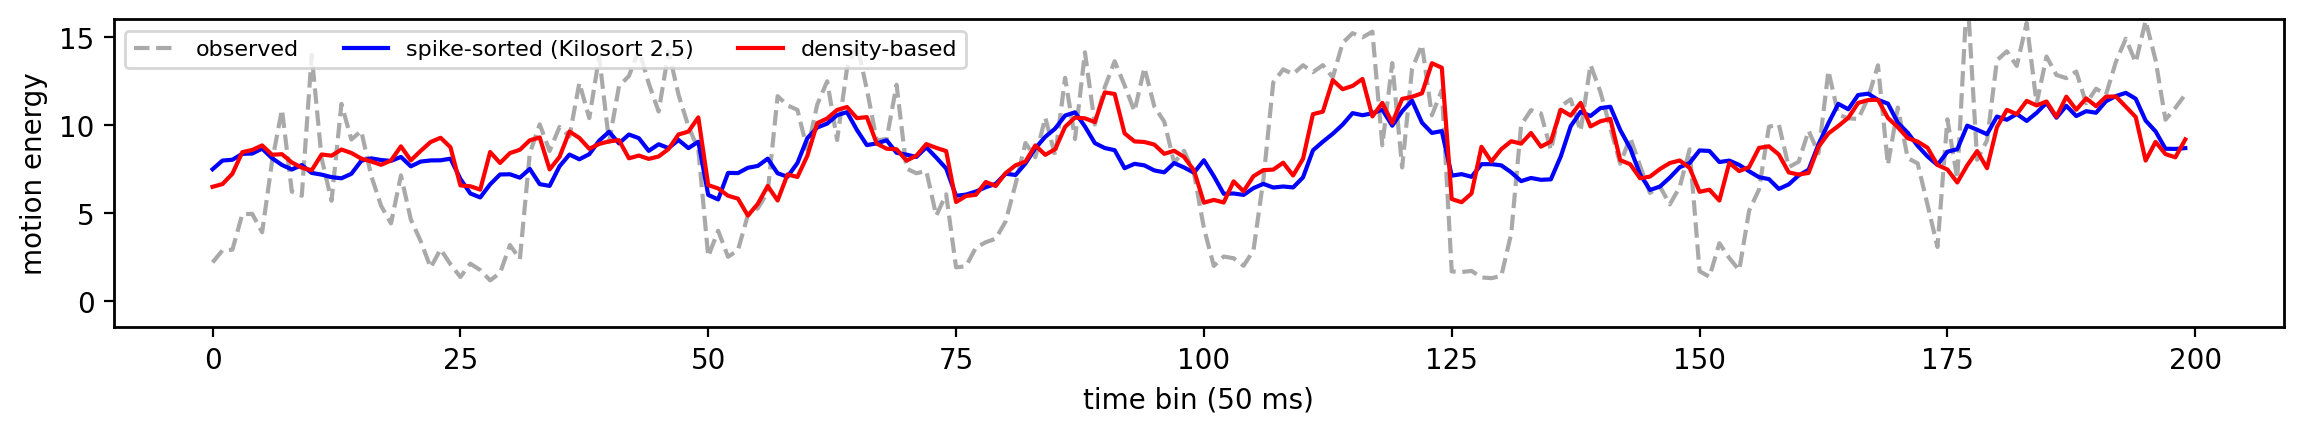

In [18]:
plt.figure(figsize=(14,2))
plt.plot(y_test[:200], c="darkgray", linestyle="--", label="observed")
plt.plot(ks_pred[:200], c="blue", linestyle="-", label="spike-sorted (Kilosort 2.5)")
plt.plot(our_pred[:200], c="red", linestyle="-", label="density-based")
plt.xlabel("time bin (50 ms)")
plt.ylabel("motion energy")
plt.legend(ncol=3, loc="upper left")
plt.ylim(-1.5, 16)
plt.show()

We can also check how decoding using only **"good" Kilosort units** that pass the quality check does:

In [19]:
good_sorted_spike_count = ibl_data_loader.load_good_sorted_units(brain_region)

found 6 good units in region visp


Compute spike count: 100%|██████████| 385/385 [00:00<00:00, 26736.10it/s]

no spikes in trial 55.
no spikes in trial 57.


In [20]:
_, _, _, _ = sliding_window_decoder(
    good_sorted_spike_count, motion_energy, train, test, behavior_type="continuous"
)

R2: 0.008, MSE: 15.792, Corr: 0.092


We can also compare our method to spike-thresholded decoder:

In [21]:
_, _, _, _ = sliding_window_decoder(
    thresholded_spike_count, motion_energy, train, test, behavior_type="continuous"
)

R2: 0.133, MSE: 13.804, Corr: 0.365


Moving onto decoding the binary choice. We usually use a smaller `n_time_bins` to decode discrete behaviors:

In [4]:
pid = "c4f6665f-8be5-476b-a6e8-d81eeae9279d"

path = "/u/yzhang39/density_decoding/data/"
file_name = f"{pid}_feats.h5"
spike_times, spike_channels, spike_features = load_data_from_h5(path, file_name)

In [5]:
ibl_data_loader = IBLDataLoader(
    pid, 
    n_t_bins = 10
)

/u/yzhang39/miniconda3/envs/density_decoding/lib/python3.11/site-packages/one/util.py:543: ALFWarning: Multiple revisions: "", "2024-05-06"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/u/yzhang39/miniconda3/envs/density_decoding/lib/python3.11/site-packages/one/util.py:543: ALFWarning: Multiple revisions: "", "2024-05-06"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


pulling data from ibl database ..
eid: e535fb62-e245-4a48-b119-88ce62a6fe67
pid: c4f6665f-8be5-476b-a6e8-d81eeae9279d
number of trials found: 385 (active: 385)


/u/yzhang39/miniconda3/envs/density_decoding/lib/python3.11/site-packages/one/util.py:543: ALFWarning: Multiple revisions: "", "2023-04-20"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


prior for this session is not found.
found 385 trials from 11.28 to 2391.34 sec.


In [6]:
choice = ibl_data_loader.process_behaviors("choice")

In [7]:
trial_idxs = np.arange(ibl_data_loader.n_trials)
random.shuffle(trial_idxs)
train, test = train_test_split(trial_idxs, test_size=0.2)

In [8]:
brain_region = "MRN".lower()

In [9]:
bin_spike_features, bin_trial_idxs, bin_time_idxs = \
    ibl_data_loader.load_spike_features(
        spike_times, spike_channels, spike_features, brain_region
    )

found 30 channels in region mrn


Process spike features: 100%|██████████| 385/385 [00:02<00:00, 140.94it/s]


In [36]:
thresholded_spike_count = ibl_data_loader.load_thresholded_units(
    spike_times, spike_channels, brain_region
)

found 30 channels in region mrn


Compute spike count: 100%|██████████| 385/385 [00:00<00:00, 4348.30it/s]


In [37]:
start_time = time.time()

weight_matrix = decode_pipeline(
    ibl_data_loader,
    bin_spike_features,
    bin_trial_idxs,
    bin_time_idxs,
    bin_behaviors = choice,
    behavior_type = "discrete",
    train = train,
    test = test,
)

end_time = time.time()

time_spent = end_time - start_time
print(f"time spent: {time_spent} seconds")

Initialize GMM: 100%|██████████| 20/20 [00:00<00:00, 20.06it/s]


Initialized a mixture with 25 components.


Compute weight matrix: 100%|██████████| 385/385 [00:02<00:00, 187.44it/s]

time spent: 357.1181240081787 seconds


In [38]:
_, _, _, _ = generic_decoder(
    weight_matrix, choice, train, test, behavior_type="discrete", verbose=True
)

accuracy: 0.844
auc: 0.843


In [39]:
_, _, _, _ = generic_decoder(
    thresholded_spike_count, choice, train, test, behavior_type="discrete", verbose=True
)

accuracy: 0.779
auc: 0.778


The choice decoding accuracy from the spike-sorted decoder is:

In [40]:
all_sorted_spike_count = ibl_data_loader.load_all_sorted_units(brain_region)

found 92 Kilosort units in region mrn


Partition brain regions:   0%|          | 0/92 [00:00<?, ?it/s]

Compute spike count: 100%|██████████| 385/385 [00:00<00:00, 4133.07it/s]


In [41]:
_, _, _, _ = generic_decoder(
    all_sorted_spike_count, choice, train, test, behavior_type="discrete", verbose=True
)

accuracy: 0.805
auc: 0.805


The accuracy using the decoder based on the "good" Kilosort units is:

In [42]:
good_sorted_spike_count = ibl_data_loader.load_good_sorted_units(brain_region)

found 5 good units in region mrn


Partition brain regions:   0%|          | 0/5 [00:00<?, ?it/s]

Compute spike count: 100%|██████████| 385/385 [00:00<00:00, 9535.32it/s]


In [43]:
_, _, _, _ = generic_decoder(
    good_sorted_spike_count, choice, train, test, behavior_type="discrete", verbose=True
)

accuracy: 0.779
auc: 0.779


#### CAVI

Although we recommend decoding everything using ADVI as the default inference method, we also include a tutorial for using CAVI for decoding binary behavioral correlates:

In [10]:
start_time = time.time()

weight_matrix = decode_pipeline(
    ibl_data_loader,
    bin_spike_features,
    bin_trial_idxs,
    bin_time_idxs,
    bin_behaviors = choice,
    behavior_type = "discrete",
    train = train,
    test = test,
    inference = "cavi",
    cavi_max_iter=10,
)

end_time = time.time()

time_spent = end_time - start_time
print(f"time spent: {time_spent} seconds")

Initialize GMM: 100%|██████████| 20/20 [00:01<00:00, 17.25it/s]


Initialized a mixture with 25 components.


Compute weight matrix: 100%|██████████| 385/385 [00:02<00:00, 185.26it/s]

time spent: 40.37338042259216 seconds


In [14]:
_, _, _, _ = generic_decoder(
    weight_matrix, choice, train, test, behavior_type="discrete", verbose=True
)